In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
import numpy as np
import pandas as pd
import gensim.downloader as api
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils import resample, shuffle
import re

In [15]:
# Load the pre-trained Word2Vec model (Google News 300-dimensional)
word2vec_model = api.load('word2vec-google-news-300')

# Check the Word2Vec embedding for a sample word (e.g., "computer")
sample_word2vec_embedding = word2vec_model['computer']
print(sample_word2vec_embedding)


[==================================================] 100.0% 1662.8/1662.8MB downloaded
[ 1.07421875e-01 -2.01171875e-01  1.23046875e-01  2.11914062e-01
 -9.13085938e-02  2.16796875e-01 -1.31835938e-01  8.30078125e-02
  2.02148438e-01  4.78515625e-02  3.66210938e-02 -2.45361328e-02
  2.39257812e-02 -1.60156250e-01 -2.61230469e-02  9.71679688e-02
 -6.34765625e-02  1.84570312e-01  1.70898438e-01 -1.63085938e-01
 -1.09375000e-01  1.49414062e-01 -4.65393066e-04  9.61914062e-02
  1.68945312e-01  2.60925293e-03  8.93554688e-02  6.49414062e-02
  3.56445312e-02 -6.93359375e-02 -1.46484375e-01 -1.21093750e-01
 -2.27539062e-01  2.45361328e-02 -1.24511719e-01 -3.18359375e-01
 -2.20703125e-01  1.30859375e-01  3.66210938e-02 -3.63769531e-02
 -1.13281250e-01  1.95312500e-01  9.76562500e-02  1.26953125e-01
  6.59179688e-02  6.93359375e-02  1.02539062e-02  1.75781250e-01
 -1.68945312e-01  1.21307373e-03 -2.98828125e-01 -1.15234375e-01
  5.66406250e-02 -1.77734375e-01 -2.08984375e-01  1.76757812e-01
  2

In [16]:
# Load datasets
d_path = '/content/drive/MyDrive/Internship/d_tweets.csv'
non_d_path = '/content/drive/MyDrive/Internship/non_d_tweets.csv'

In [17]:
d_tweet_df['label'].value_counts()

,count
label,
1,3496


In [18]:
non_d_tweet_df['label'].value_counts()

,count
label,
0,4809


In [19]:
d_tweet_df = pd.read_csv(d_path)
non_d_tweet_df = pd.read_csv(non_d_path)

# Assign labels and combine datasets
non_d_tweet_df['label'] = 0
d_tweet_df['label'] = 1




In [20]:
# Combine the data into a single DataFrame, creating 'tweet_df'
tweet_df = pd.concat([d_tweet_df[['tweet', 'label']], non_d_tweet_df[['tweet', 'label']]], ignore_index=True)

# Assuming '0' is non-depression
majority_class = tweet_df[tweet_df['label'] == 0]
minority_class = tweet_df[tweet_df['label'] == 1]

# Undersample the non-depression-class
majority_undersampled = resample(majority_class,
                                 replace=False,
                                 n_samples=len(minority_class),
                                 random_state=42)

# Combine the undersampled non-depression-class with the depression-class
tweet_df = pd.concat([majority_undersampled, minority_class])

# Shuffle the balanced dataset
tweet_df = shuffle(tweet_df).reset_index(drop=True)
print(tweet_df['label'].value_counts())

label
0    3496
1    3496
Name: count, dtype: int64


In [21]:
import nltk
# Download NLTK stopwords
nltk.download('stopwords')
# Import the stopwords object from nltk.corpus
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [26]:
def preprocess_text(text):
    # Lowercase text
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove non-alphabetical characters (punctuation, numbers)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text


In [27]:
# Apply preprocessing
tweet_df = tweets.apply(preprocess_text)

In [28]:
# Tokenize the tweets
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets)

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(tweets)

# Define maximum sequence length (based on the average tweet length)
max_sequence_length = 100

# Pad the sequences to ensure uniform length
X = pad_sequences(sequences, maxlen=max_sequence_length)

# Convert labels to a numpy array
y = labels.values


In [29]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
# Create the embedding matrix
embedding_dim = 300  # Word2Vec (Google News) has 300-dimensional vectors
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))

for word, idx in tokenizer.word_index.items():
    if word in word2vec_model:
        embedding_matrix[idx] = word2vec_model[word]


In [31]:
# Build the CNN model
model = Sequential()

# Embedding layer using pre-trained Word2Vec embeddings
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_sequence_length,
                    trainable=False))  # Freezing the Word2Vec weights

# Add convolutional layer
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

# Add max pooling layer
model.add(MaxPooling1D(pool_size=4))

# Flatten the output to feed into a Dense layer
model.add(Flatten())

# Fully connected layer
model.add(Dense(10, activation='relu'))

# Output layer for binary classification (0: non-depression, 1: depression)
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summarize the model architecture
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       4,317,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,317,600 (16.47 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,317,600 (16.47 MB)

In [34]:
# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_cnn_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

callbacks = [early_stopping, model_checkpoint]


In [35]:
# Train the model
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_test, y_test),  # Validation set
                    callbacks=callbacks)


Epoch 1/20
207/208 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7680 - loss: 0.4598
Epoch 1: val_loss improved from inf to 0.27352, saving model to best_cnn_model.keras
208/208 ━━━━━━━━━━━━━━━━━━━━ 17s 73ms/step - accuracy: 0.7687 - loss: 0.4589 - val_accuracy: 0.8796 - val_loss: 0.2735
Epoch 2/20
207/208 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9059 - loss: 0.2248
Epoch 2: val_loss improved from 0.27352 to 0.24363, saving model to best_cnn_model.keras
208/208 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - accuracy: 0.9060 - loss: 0.2248 - val_accuracy: 0.8928 - val_loss: 0.2436
Epoch 3/20
207/208 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9403 - loss: 0.1577
Epoch 3: val_loss improved from 0.24363 to 0.22833, saving model to best_cnn_model.keras
208/208 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.9403 - loss: 0.1577 - val_accuracy: 0.8995 - val_loss: 0.2283
Epoch 4/20
207/208 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9669 - loss: 0.0943
Epoch 4: val_loss did not improv

In [36]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8867 - loss: 0.2528
Test Loss: 0.22832968831062317
Test Accuracy: 0.8994581699371338


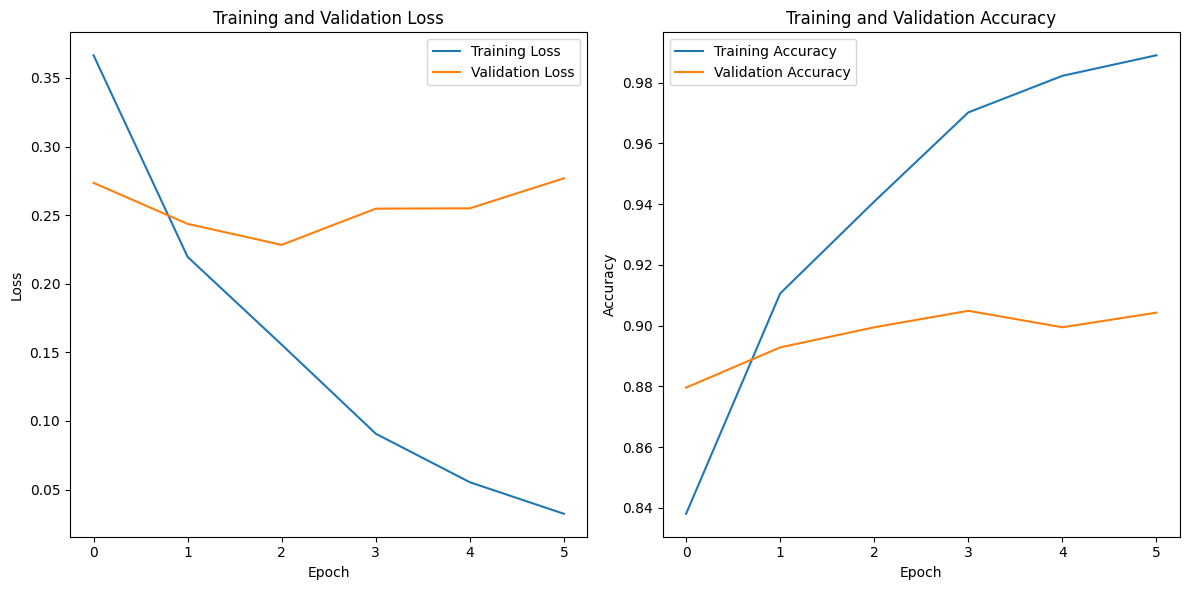

In [37]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step


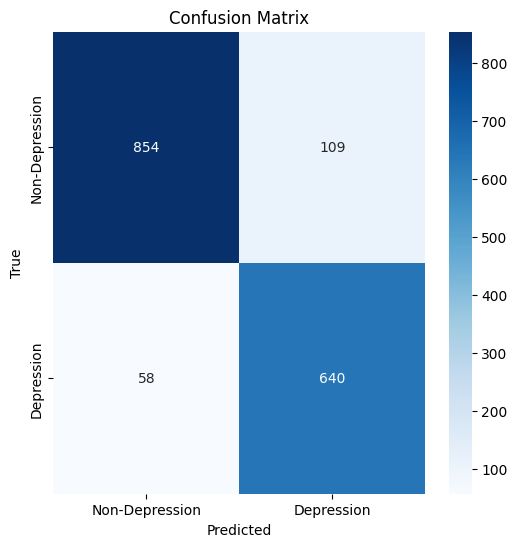

                precision    recall  f1-score   support

Non-Depression       0.94      0.89      0.91       963
    Depression       0.85      0.92      0.88       698

      accuracy                           0.90      1661
     macro avg       0.90      0.90      0.90      1661
  weighted avg       0.90      0.90      0.90      1661



In [38]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions on the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Depression', 'Depression'], yticklabels=['Non-Depression', 'Depression'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred, target_names=['Non-Depression', 'Depression']))
